# 1/ Finding edges

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import data
from scipy import ndimage

## 1.1. Basic method: derivation
We consider that edges are rapid changes in the image value do that can be seen using the derivatives :  
$\frac{\partial I}{\partial x}$ for horizontal edges, $\frac{\partial I}{\partial y}$ for vertical edges.
- The first derivative (gradient) in image processing is approximated by the operation `next pixel - previous pixel`
- The second derivative (laplacian) is approximated by `(next-current) - (current-previous)`

These operations can easily be done by **correlating** specific matrices with the input image (see Notebook n°2 so see how to do correlation).


**Before applying filters, it is recommended to perform a gaussian smoothing to remove sensitivity to noise.**

### Sobel filter
$G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$

> Smart move: This operator is separable and can be decomposed as the products of 2 kernels, which considerably speeds up the correlation operation.
$\begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix} =
\begin{pmatrix}
           1 \\
           2 \\
           1
         \end{pmatrix} \begin{pmatrix} 1 & 0 & -1
           \end{pmatrix}$

**Warning:** In some cases you might want to normalize the filter, in this case multip)ly by 1/8.

In [31]:
# can also use library ndimage.sobel. Since we do convolution instead of correlation, we use Gx[::-1], Gy[::-1]
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    return Ix, Iy

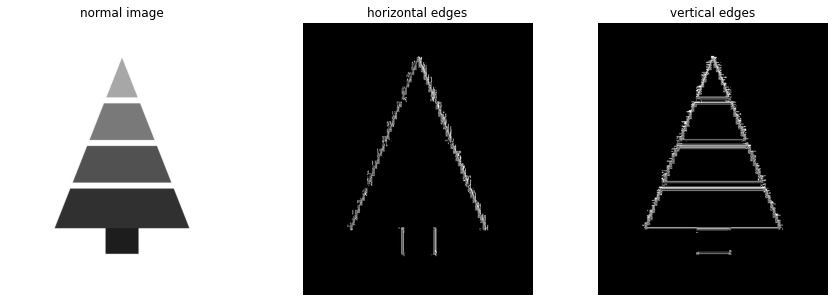

In [22]:
img = cv2.cvtColor(cv2.imread('images/tree.jpg'), cv2.COLOR_BGR2GRAY)
Ix, Iy = sobel_filters(img)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("normal image")
plt.subplot(132)
plt.imshow(Ix, cmap='gray')
plt.title("horizontal edges")
plt.axis("off")
plt.subplot(133)
plt.imshow(Iy, cmap='gray')
plt.title("vertical edges")
plt.axis("off")
plt.show()

**As said before, if we use the image as it is, all the little grain and noise is going to be displayed in the edges**. Therefore we need to erase most of it, either by first applying a gaussian smoothing or by normalizing the image:
- substract mean to center data -> will have mean of 0
- divide by standard deviation -> will have std of 1

After this, our image ranges between -3.186415 and 0.456647


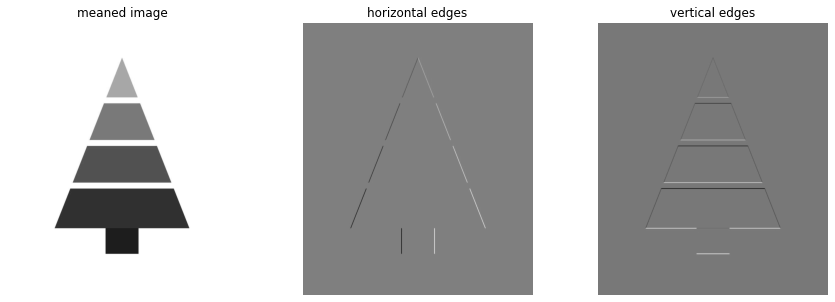

In [14]:
img = (img - img.mean()) / img.std()
print("After this, our image ranges between %f and %f"%(np.amin(img),np.amax(img)))

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("meaned image")
plt.subplot(132)
plt.imshow(ndimage.sobel(img), cmap='gray')
plt.title("horizontal edges")
plt.axis("off")
plt.subplot(133)
plt.imshow(ndimage.sobel(img, 0), cmap='gray')
plt.title("vertical edges")
plt.axis("off")
plt.show()

### Prewitt filter
$G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$

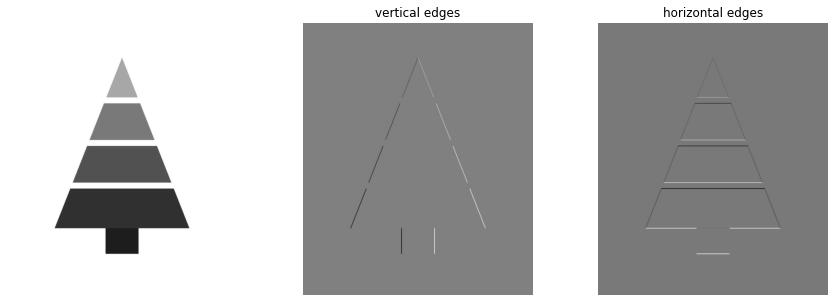

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.subplot(132)
plt.imshow(ndimage.prewitt(img), cmap='gray')
plt.title("vertical edges")
plt.axis("off")
plt.subplot(133)
plt.imshow(ndimage.prewitt(img, 0), cmap='gray')
plt.title("horizontal edges")
plt.axis("off")
plt.show()

### Smart way : derive gaussian instead of image

Actually, the derivative of a convolution (h * f) is equal to the derivative of h convolved with f !
Since we recommend to convolve a gaussian with the image before applying the derivation, therefore we can replace it by deriving the gaussian then convolve it with the image !

<img src="https://miro.medium.com/max/1838/1*Drb0Is_T_4CQB9XYa7pikQ.png" alt="derivative of convolution gaussian" width=700 />

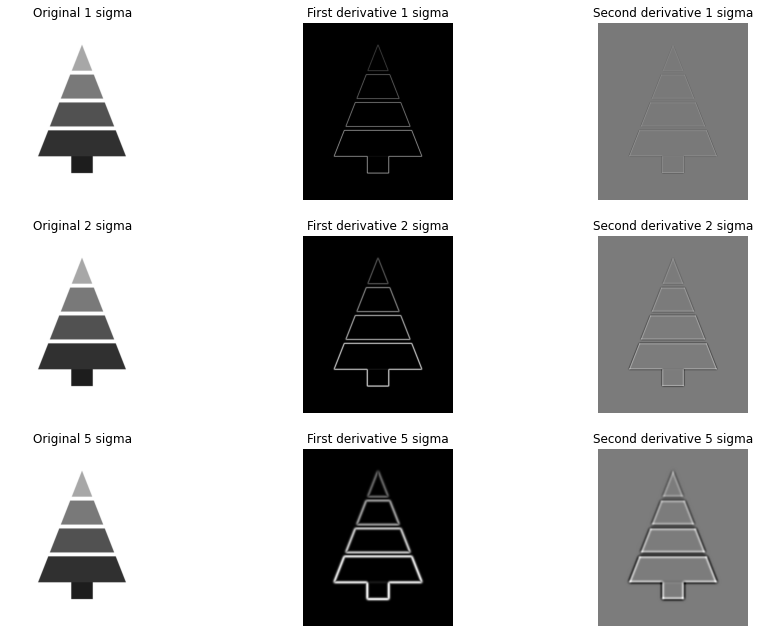

In [17]:
plt.figure(figsize=(15, 15))

for (i, sigma) in zip(range(3),[1,2,5]):
    plt.subplot(4,3,i*3+1)
    plt.imshow(img, cmap='gray')
    plt.title('Original %d sigma'%sigma)
    plt.axis('off')
    plt.subplot(4,3,i*3+2)
    plt.imshow(ndimage.gaussian_gradient_magnitude(img, sigma=sigma), cmap='gray')
    plt.axis('off')
    plt.title('First derivative %d sigma'%sigma)
    plt.subplot(4,3,i*3+3)
    plt.imshow(ndimage.gaussian_laplace(img, sigma=sigma), cmap='gray')
    plt.axis('off')
    plt.title('Second derivative %d sigma'%sigma)
plt.show()

## 1.2. Canny edge detector

### OpenCV version
https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html
Canny detector takes as parameters minVal and maxVal. See here how they influence the results.

Left : maxVal increases							Right : minVal increases
Edge pixels are going to be less and less chosen		Edges pixels are less and less joined together


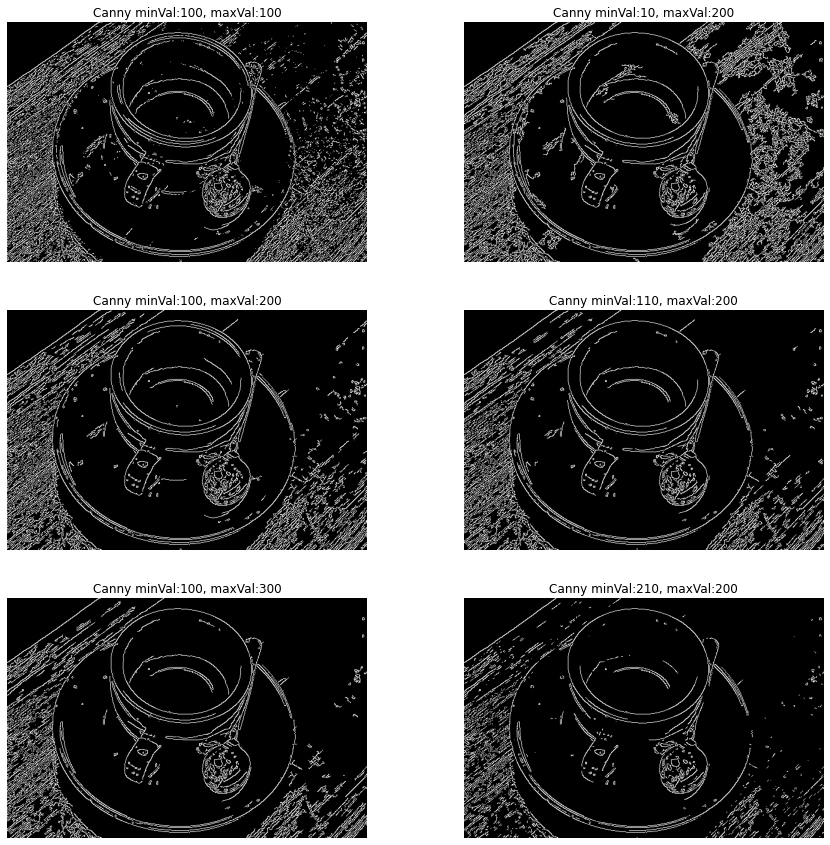

In [23]:
img = data.coffee()

print('Left : maxVal increases\t\t\t\t\t\t\tRight : minVal increases')
print('Edge pixels are going to be less and less chosen\t\tEdges pixels are less and less joined together')

plt.figure(figsize=(15, 15))
for i in range(3):
    # MaxVal increase
    plt.subplot(3,2,i*2+1)
    plt.imshow(cv2.Canny(img,100,100+i*100), cmap='gray')
    plt.axis('off')
    plt.title('Canny minVal:100, maxVal:%d'%(100+i*100))

    
    # MinVal increase
    plt.subplot(3,2,i*2+2)
    plt.imshow(cv2.Canny(img,10+i*100,250), cmap='gray')
    plt.axis('off')
    plt.title('Canny minVal:%d, maxVal:200'%(10+i*100))
plt.show()


### Custom implementation of canny edge detector
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123

#### 1. Gaussian blur to remove noise

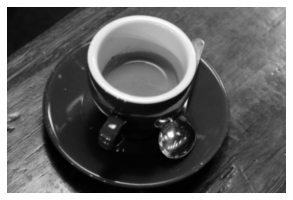

In [26]:
canny = ndimage.gaussian_filter(cv2.cvtColor(data.coffee(), cv2.COLOR_BGR2GRAY),sigma=1)
plt.figure(figsize=(5, 5)),plt.imshow(canny, cmap='gray'),plt.axis('off'),plt.show()
canny = (canny - canny.mean())/canny.std()

#### 2. Gradient computation

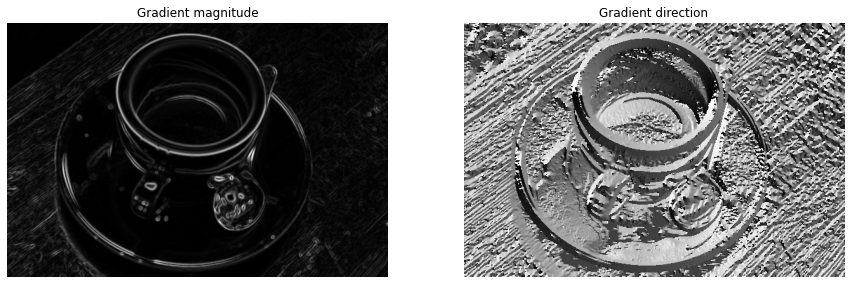

In [27]:
def gradient_computation(img):
    Ix, Iy = sobel_filters(img)
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

plt.figure(figsize=(15, 15))
(Gmag, Gdir) = gradient_computation(canny)
plt.subplot(121)
plt.imshow(Gmag, cmap='gray'),plt.axis('off'),plt.title('Gradient magnitude')
plt.subplot(122)
plt.imshow(Gdir, cmap='gray'),plt.axis('off'),plt.title('Gradient direction')
plt.show()

#### 3. Thinning

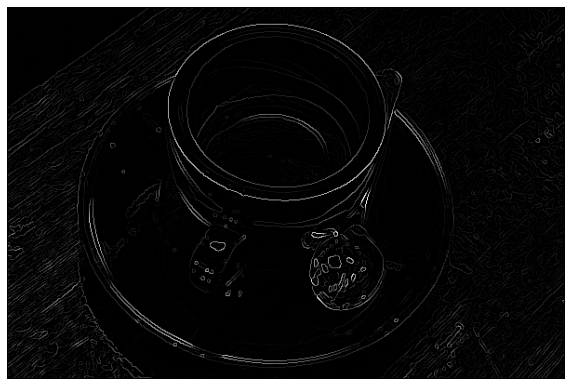

In [28]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z

canny = non_max_suppression(Gmag,Gdir)
plt.figure(figsize=(10, 10))
plt.imshow(canny, cmap='gray')
plt.axis('off')
plt.show()

#### 4. Hysteresis thresholding
Feeling too lazy to finish.

# 2/ Finding lines

## Hough transform

### Theory

1. For a line in Cartesian coordinates y = m_o * x + b_o in Image space , we can represent it as a dot in the Hough space using coordinates (m, b)

<img src="./images/line_in_space.png" width="500">

2. For a point (x_o, y_o) in Image space, any line going through this point must satisfy y_o = m * x_o + b .  This gives us a line in Hough space.

<img src="./images/point_in_space.png" width="500">

3. For a set of points in Image space, each of them vote for a line in Hough space. In order to know which line best goes through all these points, we select the bin (made with grid) in Hough space containing the most votes.

<img src="./images/bins.png" width="500">

4. The problem with using Cartesian coordinates in Hough space like b = -x_o * m + y_o is that it can trigger numerical problems, like infinite slope. Therefore we prefer a polar representation of lines, more robust.

<img src="./images/polar.png" width="500">

For a point in Image space, x and y are fixed so only d and theta vary. This gives us a sinusoid.
Therefore a **a point in Image space equals a sinusoid in Hough space**. And the bins where the sinusoids encounter the most are the lines we are looking for.

<img src="https://scikit-image.org/docs/0.11.x/_images/plot_line_hough_transform_1.png" >


### Hough algorithm

We use the polar parametrization, and a **Hough accumutator array** (x=theta, y=d) which recors number of votes in bins.

1. Initalize H[d,theta] = 0
2. For each *edga point* (x,y) (obtained before via Canny for instance) in the image :
        for theta = 0 to 180
            d = x * cos(theta) - y * sin (theta) // - car dans sens trigo alors que dessus sens horaire?
            H(d, theta] += 1 // record vote
3. Find the values of (d, theta) where H[d, theta] is max -> **Hough peaks**
4. We obtain the lines in the image with y * sin(theta) = x * cos(theta) - d

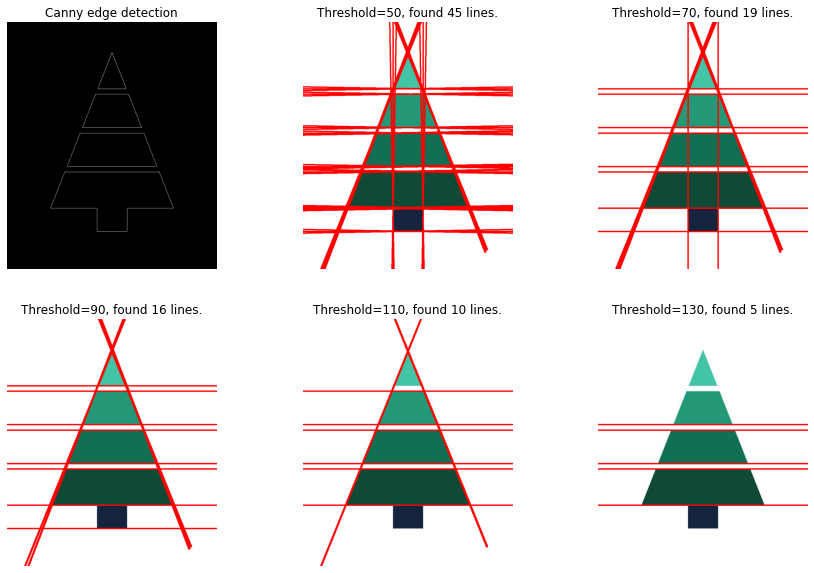

In [32]:
import math

img = cv2.imread('images/tree.jpg')
edges = cv2.Canny(img,100,200)

plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.imshow(edges, cmap='gray')
plt.title('Canny edge detection')
plt.axis('off')

def show_hough(image, threshold):
    edges = cv2.Canny(image,100,200)
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold)

    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a*rho
        y0 = b*rho
        p1 = (int(round(x0 + 1000*(-b))),int(round(y0 + 1000*(a))))
        p2 = (int(round(x0 - 1000*(-b))),int(round(y0 - 1000*(a))))
        cv2.line(image, p1, p2, (255, 0, 0), thickness=3, lineType=8)
    return f'Threshold={threshold}, found {np.shape(lines)[0]} lines.'


for i in range(5):
    plt.subplot(2,3,i+2)
    image = img.copy()
    msg = show_hough(image, 50+20*i)
    plt.imshow(image)
    plt.title(msg)
    plt.axis('off')
plt.show()

### With Skimage, show Hough accumulator

<Figure size 432x288 with 0 Axes>

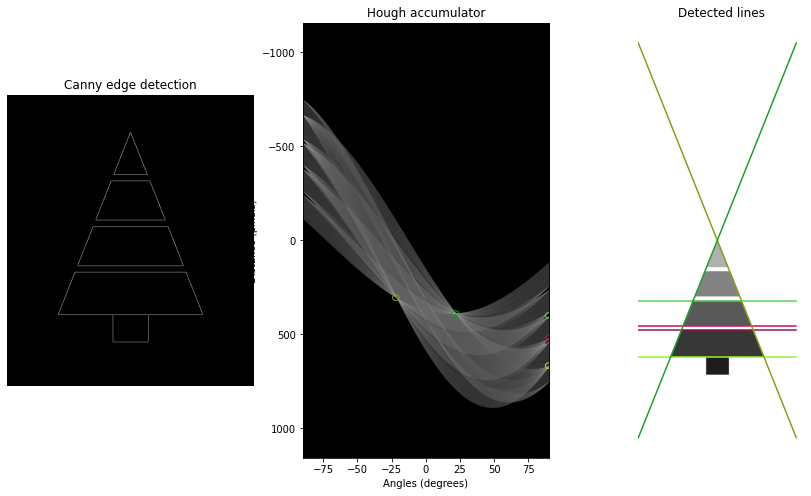

In [27]:
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from matplotlib.patches import Ellipse
from skimage import io
from skimage.feature import canny
from skimage.color import rgb2gray

plt.clf()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,8))

img = rgb2gray(io.imread('images/tree.jpg'))
edges = canny(img, low_threshold=0.1, high_threshold=0.2)
ax[0].imshow(edges, cmap='gray')
ax[0].set_title('Canny edge detection')
ax[0].axis('off')

h, theta, d = hough_line(edges, theta=np.linspace(-np.pi / 2, np.pi / 2, 360))


# draw hough accumulator
ax[1].imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[0]), np.rad2deg(theta[-1]),d[-1], d[0]],
           cmap=plt.cm.gray)
ax[1].set_title('Hough accumulator')
ax[1].set(xlabel='Angles (degrees)',ylabel='Distance (pixels)')
ax[1].axis('auto')
points = []
rows, cols = img.shape
# draw points in accumulator which correspond to a line
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    color = np.random.rand(3,)
    circle = Ellipse((np.rad2deg(angle),dist), 5,30, color=color, fill=False)
    ax[1].add_artist(circle)
    points.append(((dist - 0 * np.cos(angle)) / np.sin(angle),
                   (dist - cols * np.cos(angle)) / np.sin(angle),
                  color))


ax[2].imshow(img, cmap=plt.cm.gray)
for p in points:
    ax[2].plot((0, cols), (p[0],p[1]), color=p[2])
ax[2].set_title('Detected lines')
ax[2].axis('off')
plt.show()

## General Hough Transform
https://github.com/vmonaco/general-hough (need a few corrections, like convertion of input images as uint8 and 2 channels)

For complicated stuff: library ITK

# 3/ Finding corners

*C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988.*

The Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$, Prewitt or Sobel.

The general method from this <a href="https://muthu.co/harris-corner-detector-implementation-in-python/">Tuto in python</a> (on **greyscale** image):
 1. Spatial derivative calculation: $I_x$ and $I_y$. We can use the Sobel kernel.
 2. Structure tensor setup : convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N.
 3. Harris response calculation : $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. 
 4. Find edges and corners using R : "clean" the response like we did for Canny edge detector by thresholding, then non-max suppression.

In [11]:
def harris_response(image,sigma,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    offset = int(sigma/2)
    Ix, Iy = sobel_filters(image)
    Ixx = ndimage.gaussian_filter(Ix**2, sigma)
    Iyy = ndimage.gaussian_filter(Iy**2, sigma)
    Ixy = ndimage.gaussian_filter(Ix*Iy, sigma)
    
    # determinant
    detA = Ixx * Iyy - Ixy ** 2
    # trace
    traceA = Ixx + Iyy
    R = detA - kappa*(traceA**2)
    return R

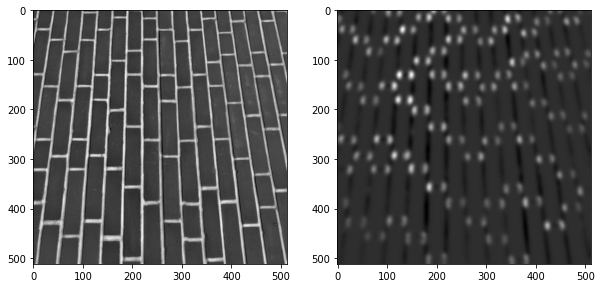

In [14]:
img = np.float32(data.brick())
harris = harris_response(img, 5, 0.04)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(harris, cmap='gray')
plt.show()

In [18]:
def non_max_suppression(R, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    Rlocmax = np.zeros(R.shape)
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            condition = True
            if i == 0:
                condition = R[i,j] > R[i+1,j]
            elif i == R.shape[0]-1:
                condition = R[i,j] > R[i-1,j]
            else:
                condition = R[i,j] > R[i+1,j] and R[i,j] > R[i-1,j]
            if j == 0:
                condition = condition and R[i,j] > R[i,j+1]
            elif j == R.shape[1]-1:
                condition = condition and R[i,j] > R[i,j-1]
            else:
                condition = condition and R[i,j] > R[i,j+1] and R[i,j] > R[i,j-1]
            if Rbin[i,j] and condition:
                Rlocmax[i,j] = 1
    return Rlocmax

def harris_corner_detector(image, sigma, kappa):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    # get harris response
    harris = harris_response(img, sigma, kappa)
    # threshold
    Rbin = harris>=harris.max()*0.01
    return non_max_suppression(harris, Rbin)

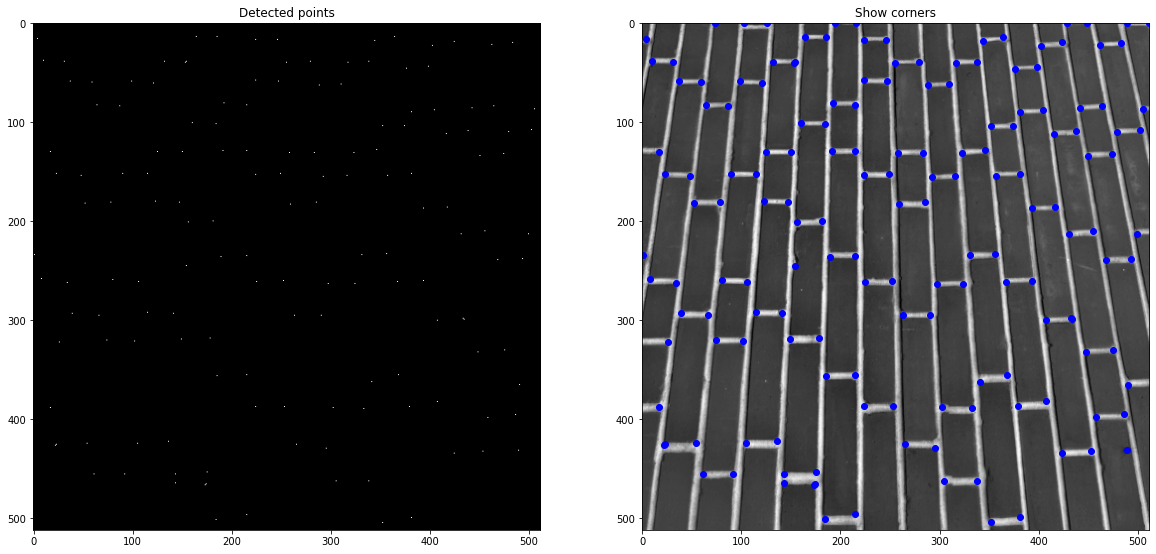

In [21]:
corners = harris_corner_detector(img, sigma=5, kappa=0.04)

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(corners, cmap='gray')
ax[0].set_title("Detected points")
ax[1].imshow(img, cmap='gray')
ax[1].set_title("Show corners")
y,x = np.nonzero(corners)
plt.scatter(x, y, c='b')
plt.show()

This corner detector works very well on zones with geometric structures, like buildings, etc.

## Properties / invariance of Harris corner detector


(672, 529)
Min :-340104.9375, Max : 2984877.0
(671, 507)
Min :-64143.296875, Max : 1363643.5


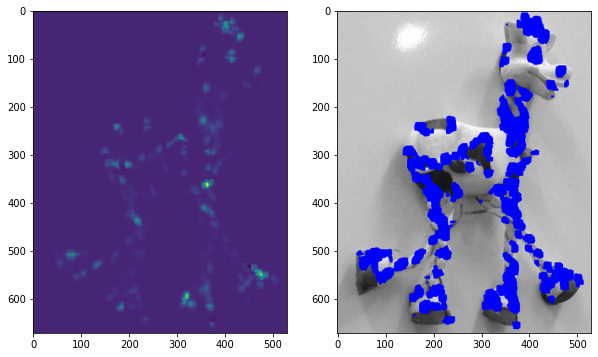

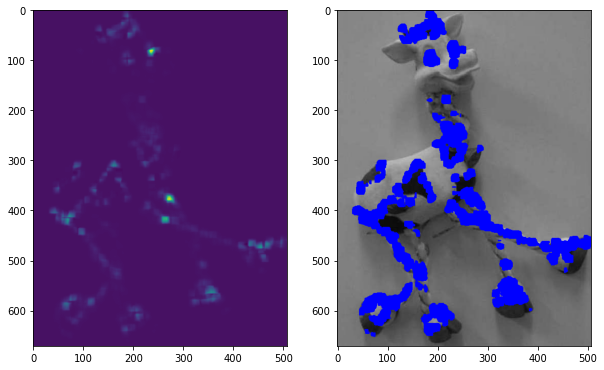

In [24]:
for filename in ('images/toyHorse1.png', 'images/toyHorse2.png'):
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(gray.shape)

    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,15,3,0.04)
    print(f"Min :{dst.min()}, Max : {dst.max()}")
    ax[0].imshow(dst)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]

    ax[1].imshow(img)
    plt.plot()

Although we have between the 2 images:
* Change of luminosity
* Rotation of body
* Rotation of head  

We see we detect a lot of same corners !

**Warning:** however, it's not **scale** invariant !